## CAMELs sims

Just check we can load and plot the 2D CAMELs fields from IllustrisTNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from kymatio.numpy import Scattering2D
from sn_camels.models.models_factory import baseModelFactory, topModelFactory
from sn_camels.models.sn_hybrid_models import sn_HybridModel
import torch

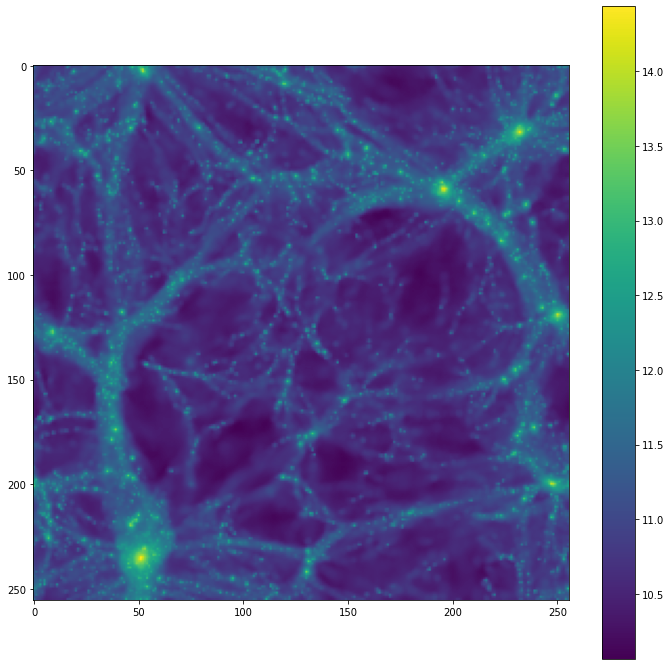

In [2]:
data_string=os.environ['CAMELS_PATH']+"/Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
param_string=os.environ['CAMELS_PATH']+"/params_IllustrisTNG.txt"

## Import maps and parameters
maps = np.load(data_string)
params=np.loadtxt(param_string)

maps=maps[:10]

##Pick a field, any field
field_index=np.random.randint(len(maps))

plt.figure(figsize=(12,12))
plt.imshow(np.log10(maps[field_index]))
plt.colorbar()

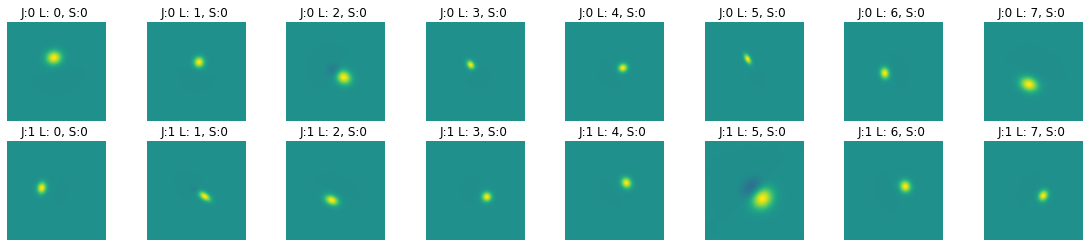

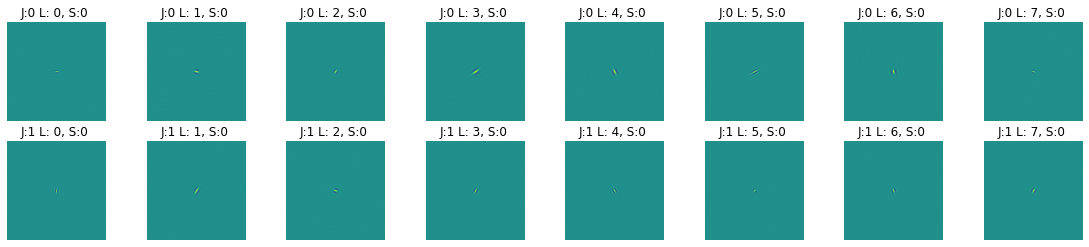

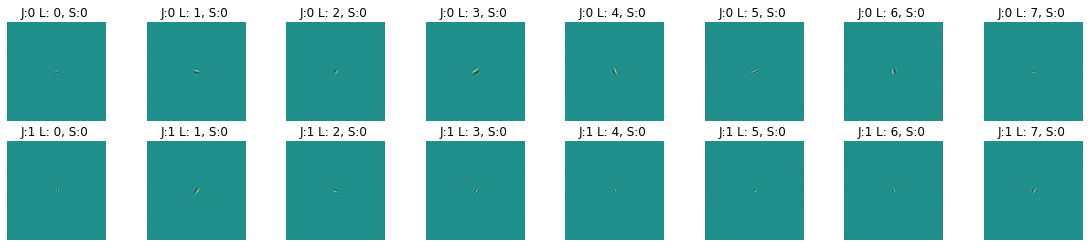

In [9]:
## Make one of our sn_camels models
scatteringBase = baseModelFactory( #creat scattering base model
    architecture='scattering',
    J=2,
    N=256,
    M=256,
    second_order=True,
    initialization="Random",
    seed=123,
    learnable=False,
    lr_orientation=0.1,
    lr_scattering=0.1,
    skip=False,
    split_filters=False,
    subsample=1,
    filter_video=False,
    device="cpu",
    use_cuda=False
)


In [10]:
def scattering2d_learn(x, pad, unpad, backend, J, L, phi, psi, max_order,
        out_type='array'):
    """ Function to take an input image and perform a series of scattering
    convolutions."""
    subsample_fourier = backend.subsample_fourier
    modulus = backend.modulus
    fft = backend.fft
    cdgmm = backend.cdgmm
    concatenate = backend.concatenate

    # Define lists for output.
    out_S_0, out_S_1, out_S_2 = [], [], []
    
    ## Map to complex
    complex_maps = x.new_zeros(x.shape + (2,))
    complex_maps[..., 0] = x

    U_0_c = fft(complex_maps, 'C2C')

    # First low pass filter
    U_1_c = cdgmm(U_0_c, phi[0])
    #U_1_c = subsample_fourier(U_1_c, k=2 ** J)


    S_0 = fft(U_1_c, 'C2R', inverse=True)

    out_S_0.append({'coef': S_0,
                    'j': (),
                    'theta': ()})

    for n1 in range(len(psi)):
        j1 = psi[n1]['j'] ## don't care about this any more
        theta1 = psi[n1]['theta']

        ## Wavelet convolution
        U_1_c = cdgmm(U_0_c, psi[n1][0])

        U_1_c = fft(U_1_c, 'C2C', inverse=True)
        U_1_c = modulus(U_1_c)
        U_1_c = fft(U_1_c, 'C2C')

        ## Second low pass filter
        S_1_c = cdgmm(U_1_c, phi[0])
        ## No subsampling for now
        #S_1_c = subsample_fourier(S_1_c, k=2 ** (J))

        S_1_r = fft(S_1_c, 'C2R', inverse=True)

        out_S_1.append({'coef': S_1_r,
                        'j': (j1,),
                        'theta': (theta1,)})

        if max_order < 2:
            continue
        for n2 in range(len(psi)):
            j2 = psi[n2]['j']
            theta2 = psi[n2]['theta']
            

            U_2_c = cdgmm(U_1_c, psi[n2][0])
            # No subsampling for now
            #U_2_c = subsample_fourier(U_2_c, k=2 ** (j2 - j1))
            U_2_c = fft(U_2_c, 'C2C', inverse=True)
            U_2_c = modulus(U_2_c)
            U_2_c = fft(U_2_c, 'C2C')

            ## Low pass filter
            S_2_c = cdgmm(U_2_c, phi[0])
            
            # No subsampling for now
            #S_2_c = subsample_fourier(S_2_c, k=2 ** (J - j2))

            S_2_r = fft(S_2_c, 'C2R', inverse=True)
            

            out_S_2.append({'coef': S_2_r,
                            'j': (j1, j2),
                            'theta': (theta1, theta2)})

    out_S = []
    out_S.extend(out_S_0)
    out_S.extend(out_S_1)
    out_S.extend(out_S_2)

    if out_type == 'array':
        out_S = concatenate([x['coef'] for x in out_S])

    return out_S

In [11]:
out=scattering2d_learn(torch.tensor(maps), scatteringBase.scattering.pad, scatteringBase.scattering.unpad, scatteringBase.scattering.backend, scatteringBase.scattering.J,
                        scatteringBase.scattering.L, scatteringBase.scattering.phi, scatteringBase.scattering.psi, scatteringBase.scattering.max_order, scatteringBase.scattering.out_type)

## Plot some convolutions

In [33]:
filter_1=2
filter_2=5
order2_index=17+filter_1*16+filter_2

cdm_map_num=7 # between 0 and 10

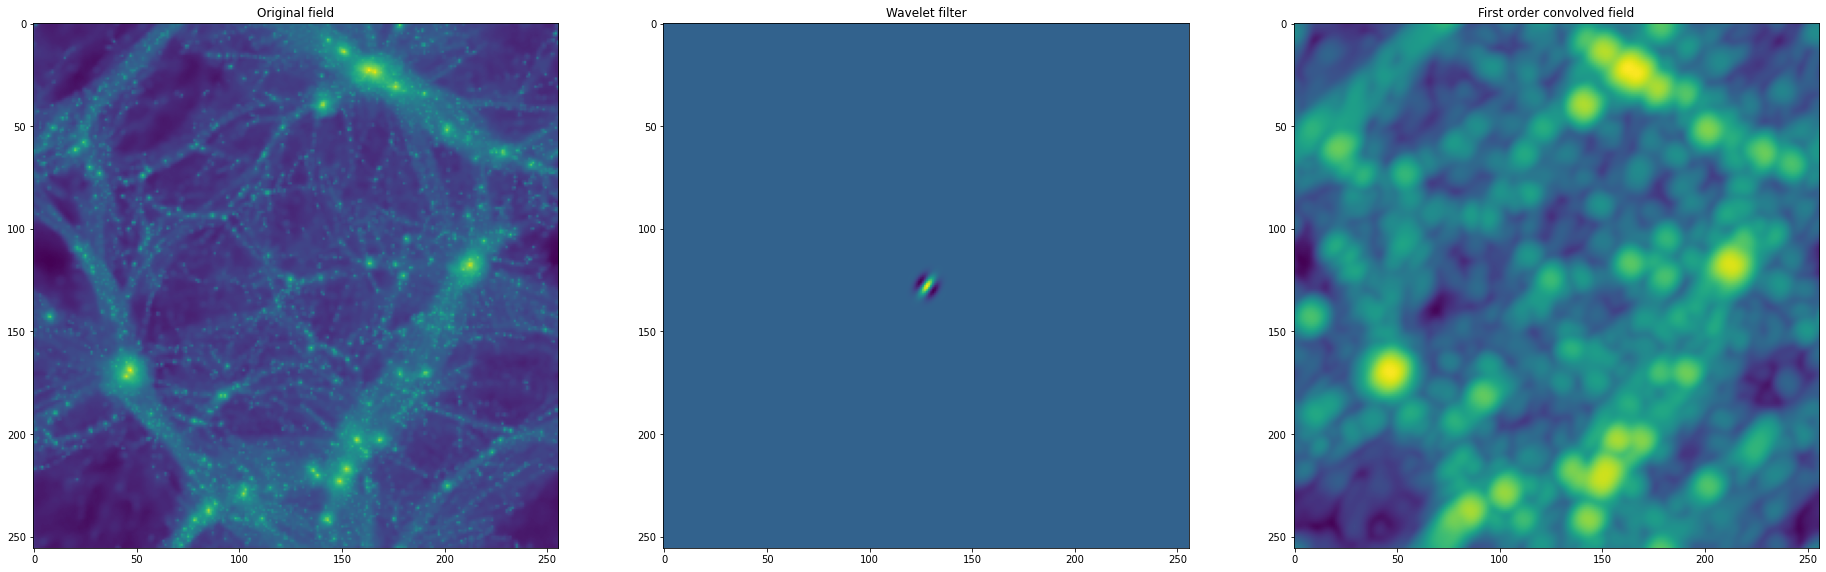

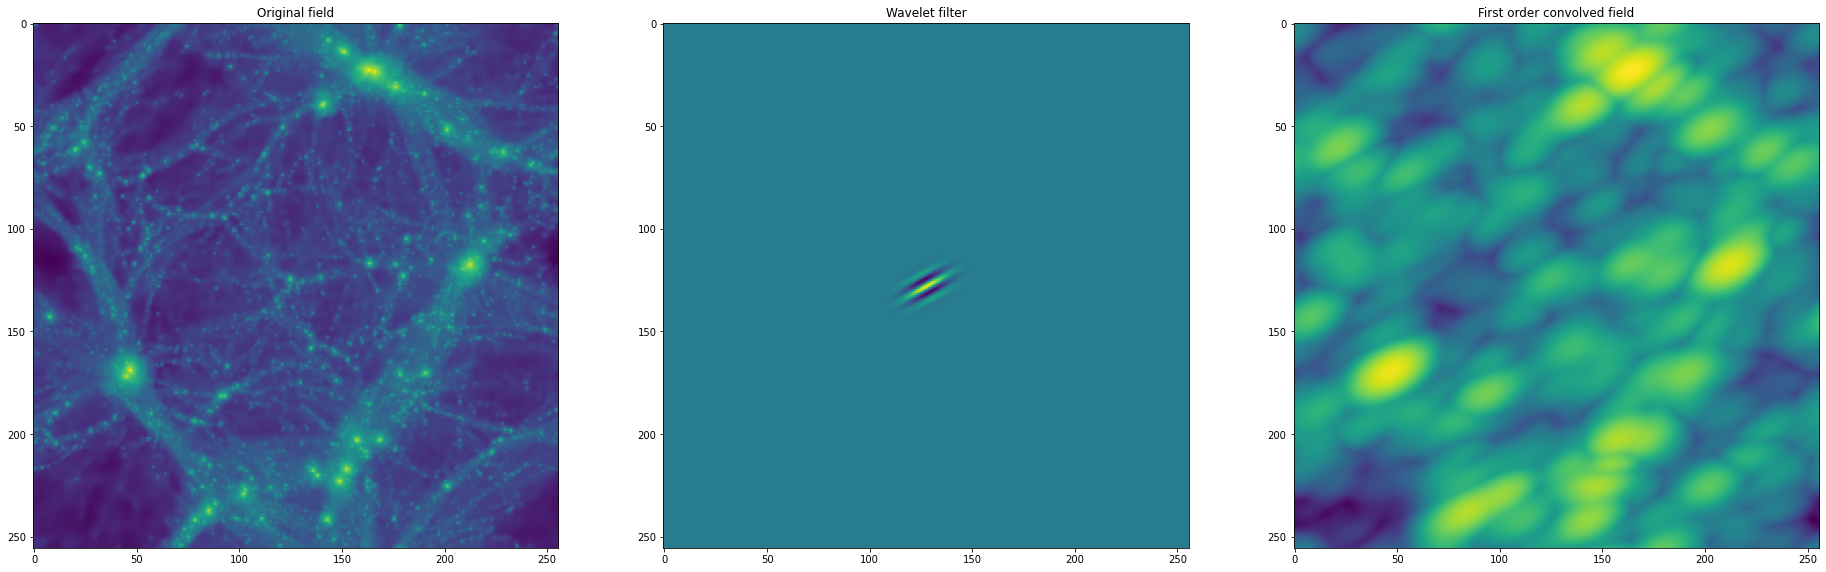

In [34]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_1][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("Original field")
plt.imshow(np.log10(maps[cdm_map_num]))
plt.subplot(1, 3, 2)
plt.title("Wavelet filter")
plt.imshow(np.fft.fftshift(np.fft.ifft2(scatteringBase.scattering.psi[filter_2][0].squeeze().cpu().detach().numpy())).real)
plt.subplot(1, 3, 3)
plt.title("First order convolved field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))

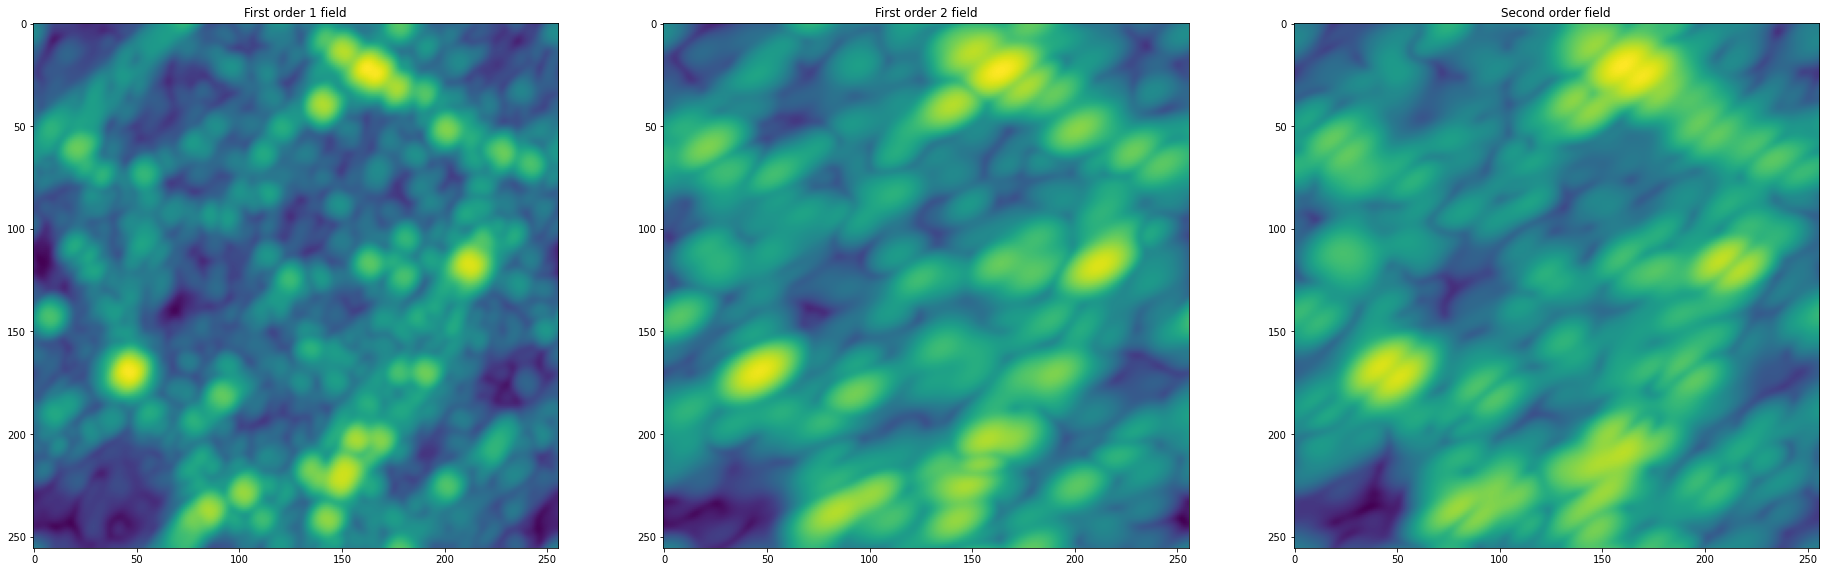

In [35]:
plt.figure(figsize=(32,22))
plt.subplot(1, 3, 1)
plt.title("First order 1 field")
plt.imshow(np.log10(out[cdm_map_num][filter_1+1]))
plt.subplot(1, 3, 2)
plt.title("First order 2 field")
plt.imshow(np.log10(out[cdm_map_num][filter_2+1]))
plt.subplot(1, 3, 3)
plt.title("Second order field")
plt.imshow(np.log10(out[cdm_map_num][order2_index]))